# Prise en main des concepts du Deep Learning

<br/>

##### Arnaud Deleruyelle : Doctorant SIGMA - BioComputing
##### Encadrement: John Klein (SIGMA) - Cristian Versari (BioComputing)

## Partie 1 : Initialisation du code

Nous allons traiter ce travail à l'aide de la bibliothèque Tensorflow de Google. 
Cette partie va se consacrer à la gestion des imports, la création des données etc...

### Section 1.1: Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import sin
from IPython.core.display import Image, display

### Section 1.2: Création d'un dataset artificiel

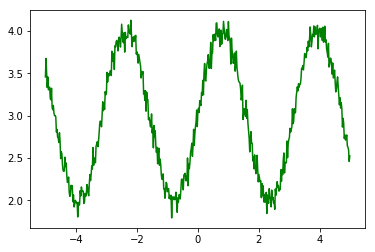

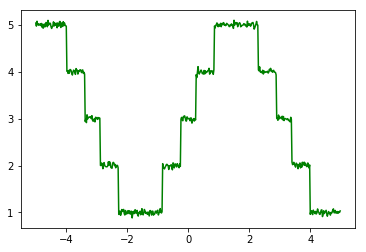

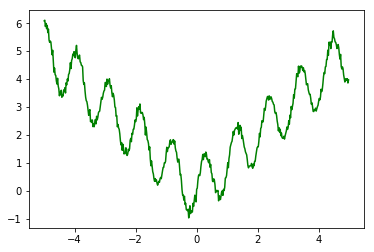

In [2]:
# dataset

def f_sin(x): return sin(2*x) + 3

def f_round(x): return round(2*sin(x) + 3)

def f_absin(x): return sin(6*x) + abs(x)


x = np.arange(-5, 5, 0.02).reshape(-1,1)
y_f1 = np.array([f_sin(x) + np.random.normal(0, 0.08) for x in x]).reshape(-1,1)
y_f2 = np.array([f_round(x) + np.random.normal(0, 0.04) for x in x]).reshape(-1,1)
y_f3 = np.array([f_absin(x) + np.random.normal(0, 0.1) for x in x]).reshape(-1,1)


plt.plot(x,y_f1, 'green')
plt.show()

plt.plot(x,y_f2, 'green')
plt.show()

plt.plot(x,y_f3, 'green')
plt.show()


### Section 1.3: Variables Globales

In [3]:
epochs = 10000
batch_size = 100

x_batch = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='x_batch')
y_batch = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='y_batch')

### Section 1.4: Fit

In [4]:
def Fit(x_train,y_train,model, verbose = 2000):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    for epoch in range(epochs):
        indices = np.random.choice(x_train.shape[0], size=batch_size)
        x_b = x_train[indices]
        y_b = y_train[indices]
        feed_dict = {x_batch: x_b, y_batch: y_b}
        sess.run(model, feed_dict=feed_dict)
        if epoch%verbose ==0:
            print("Loss = ", sess.run(avg_llh, feed_dict=feed_dict))
    return sess

### Section 1.5: Predict

In [5]:
def Predict(x_test,session):
    x_b = np.hstack([x_test.reshape((-1,1))])
    feed_dict = {x_batch: x_b}
    yh_vals = session.run((y_pred), feed_dict=feed_dict)
    return yh_vals

    

### Section 1.6: MLP

In [6]:
def MLP(x_b,tab_neurones, tab_activation, name="MLP"):
    with tf.name_scope(name):
        outs = []
        for i in range(len(tab_neurones)):
            if i == 0 :
                input_nb_neurone = x_b.shape[1]
                input_data = x_b
            else:
                input_nb_neurone = tab_neurones[i-1]
                input_data = outs[i-1]
            W = tf.Variable(np.random.rand(input_nb_neurone,tab_neurones[i]), dtype=tf.float64, name="W")
            b = tf.Variable(np.random.rand(tab_neurones[i]), dtype=tf.float64, name="b")
            if (tab_activation[i] == "relu"):
                out = tf.nn.relu(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "sigmoid"):
                out = tf.nn.sigmoid(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "tanh"):
                out = tf.tanh(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "softmax"):
                out = tf.nn.softmax(tf.matmul(input_data, W) + b)
            else:
                out = tf.matmul(input_data, W) + b
            outs.append(out)
        return outs
        

### Section 1.7: Test d'un modèle

In [7]:
mlp1 = MLP(x_batch,[8,8,1], ['tanh','tanh','identity'])

# output layer
y_pred = mlp1[-1]

with tf.name_scope("loss"):
    # loss function
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model = opt.minimize(avg_llh)

In [8]:
# fit the model
modelFit = Fit(x,y_f1,model)

Loss =  15.416150802513632
Loss =  0.20054659561327776
Loss =  0.038089311739138536
Loss =  0.009159187423849517
Loss =  0.00781437093636444


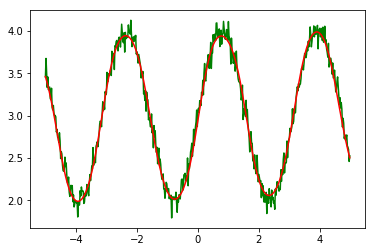

In [9]:
# predict 
modelPredict = Predict(x,modelFit)

plt.plot(x,y_f1, 'green')
plt.plot(x,modelPredict, 'red')
plt.show()

In [10]:
writer = tf.summary.FileWriter("/tmp/graph/1")
writer.add_graph(modelFit.graph)

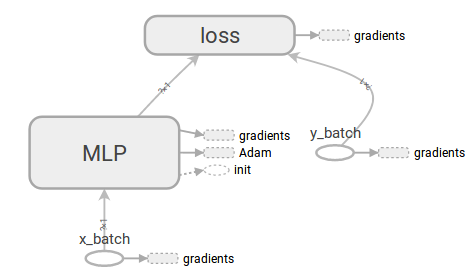

In [11]:
Image(filename = "/home/adeleruyelle/Images/tsb1.png", width=500, height=500)

## Partie 2: Utilisation des différentes fonctions d'activation.

Dans cette partie, nous allons étudier les 4 fonctions d'activation (Relu, sigmoide, tanh, identité).
Pour ce faire, nous avons choisi un optimiseur (Adam) de manière à ne changer que la couche d'activation.

### Section 2.1: fonction de test

In [12]:
# mse

def mse(y_pred,y):
    return np.mean(np.square(y_pred - y))

npArray1 = np.array([1,2,4])
npArray2 = np.array([1,3,7])

print("mse = " + str(mse(npArray1,npArray2)))

# mae

def mae(y_pred,y):
    return np.mean(np.abs(y_pred - y))

print("mae = " + str(mae(npArray1,npArray2)))

mse = 3.3333333333333335
mae = 1.3333333333333333


In [13]:
# test with mean of n launch

def testFunctionActivation(n, x_vals, y_vals, model):
    liste_result = []
    for i in range(n):
        session = Fit(x_vals, y_vals, model, verbose = 5000)
        y_result = Predict(x_vals,session)
        liste_result.append(y_result)
        session.close()
    result = np.mean(liste_result, axis = 0)
    return result.reshape(result.shape[0],1)
        

### Section 2.2: Relu

In [14]:
# model with Relu

mlp_relu = MLP(x_batch,[8,8,8,1], ['relu','relu','relu','identity'])

# output layer
y_pred = mlp_relu[-1]

with tf.name_scope("loss"):
    # loss function
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelRelu = opt.minimize(avg_llh)

In [15]:
# train model
resRelu_sin = testFunctionActivation(5,x,y_f1,modelRelu)
resRelu_round = testFunctionActivation(5,x,y_f2,modelRelu)
resRelu_absin = testFunctionActivation(5,x,y_f3,modelRelu)

Loss =  5028.941924772601
Loss =  0.43667911049146524
Loss =  6432.664562828607
Loss =  0.43305485275065253
Loss =  4860.288877309511
Loss =  0.48387288012413504
Loss =  4842.158224034769
Loss =  0.4674328848202714
Loss =  5331.568389807532
Loss =  0.4359612346838837
Loss =  6331.571546004158
Loss =  0.14281396687268455
Loss =  5137.022983324778
Loss =  0.13270509768203798
Loss =  6938.318880065644
Loss =  0.13480649069541958
Loss =  6507.0728934277695
Loss =  0.1111672954973558
Loss =  5770.6375882612165
Loss =  0.13579269753343592
Loss =  5615.431185313849
Loss =  0.5358062315368478
Loss =  6262.672927983879
Loss =  0.4956807853613469
Loss =  4826.108259629234
Loss =  0.4697188210392419
Loss =  5911.334371146279
Loss =  0.4965020837534388
Loss =  5367.815317517654
Loss =  0.35148448564546547


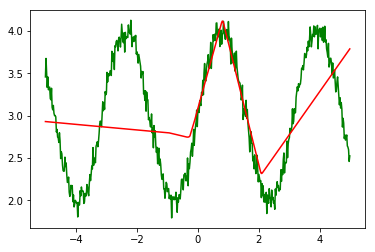

mae = 0.45207557738044507
mse = 0.3158712581939163


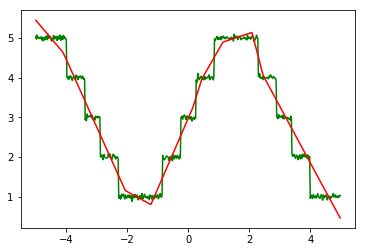

mae = 0.22954855452488704
mse = 0.0823684998075391


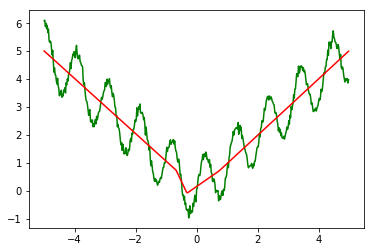

mae = 0.6336967038407599
mse = 0.498722148943776


In [16]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resRelu_sin, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_sin,y_f1)))
print( "mse = " + str(mse(resRelu_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resRelu_round, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_round,y_f2)))
print( "mse = " + str(mse(resRelu_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resRelu_absin, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_absin,y_f3)))
print( "mse = " + str(mse(resRelu_absin,y_f3)))

### Section 2.3: Sigmoide

In [17]:
# model with sigmoid

mlp_sigmoid = MLP(x_batch,[8,8,8,1], ['sigmoid','sigmoid','sigmoid','identity'])

# output layer
y_pred = mlp_sigmoid[-1]

#loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelSigmoid = opt.minimize(avg_llh)

In [18]:
# train model
resSigmoid_sin = testFunctionActivation(5,x,y_f1,modelSigmoid)
resSigmoid_round = testFunctionActivation(5,x,y_f2,modelSigmoid)
resSigmoid_absin = testFunctionActivation(5,x,y_f3,modelSigmoid)

Loss =  9.258487591832965
Loss =  0.09327805614964568
Loss =  9.49451394691362
Loss =  0.05158710317522214
Loss =  9.462777614516263
Loss =  0.11413534187177893
Loss =  8.869693229195175
Loss =  0.13557009151008498
Loss =  9.909132451382023
Loss =  0.05172826639502769
Loss =  10.935639125617552
Loss =  0.07179893079859534
Loss =  11.415799278693326
Loss =  0.06730413534682102
Loss =  9.383997547648413
Loss =  0.06483811253119214
Loss =  10.845602760979228
Loss =  0.06480793661437331
Loss =  10.665485842295041
Loss =  0.07560201463279456
Loss =  16.62715596290079
Loss =  0.4271734121504839
Loss =  15.630670268785092
Loss =  0.4938110273762716
Loss =  12.650543175082875
Loss =  0.45305255049758875
Loss =  16.56820734851603
Loss =  0.47575305778451726
Loss =  11.764349187562939
Loss =  0.5172567941039771


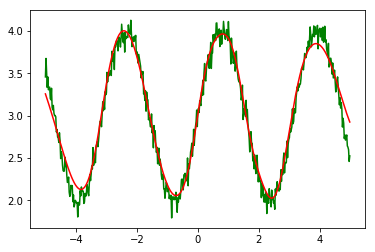

mae = 0.097412860215528
mse = 0.0157567737736423


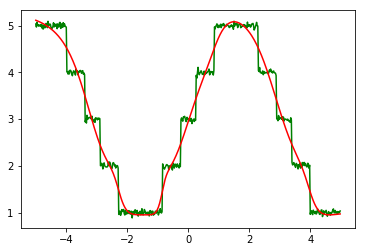

mae = 0.18783212911758698
mse = 0.058313631400520975


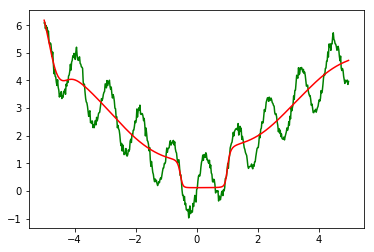

mae = 0.574358478109747
mse = 0.44310025547156046


In [19]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resSigmoid_sin, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_sin,y_f1)))
print( "mse = " + str(mse(resSigmoid_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resSigmoid_round, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_round,y_f2)))
print( "mse = " + str(mse(resSigmoid_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resSigmoid_absin, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_absin,y_f3)))
print( "mse = " + str(mse(resSigmoid_absin,y_f3)))

### Section 2.4: Tanh

In [20]:
# model with tanh

mlp_tanh = MLP(x_batch,[8,8,8,1], ['tanh','tanh','tanh','identity'])

# output layer
y_pred = mlp_tanh[-1]


# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelTanh = opt.minimize(avg_llh)

In [21]:
# train model
resTanh_sin = testFunctionActivation(5,x,y_f1,modelTanh)
resTanh_round = testFunctionActivation(5,x,y_f2,modelTanh)
resTanh_absin = testFunctionActivation(5,x,y_f3,modelTanh)

Loss =  12.272140087907779
Loss =  0.2064932996678126
Loss =  14.061511950454019
Loss =  0.34784317205116116
Loss =  9.699255756104835
Loss =  0.38700037270218746
Loss =  9.70247425337608
Loss =  0.010554362422540176
Loss =  11.681098702860673
Loss =  0.23384968752220575
Loss =  16.485852826129218
Loss =  0.0659407626990162
Loss =  14.270491268437745
Loss =  0.06232594752662262
Loss =  15.585504218357988
Loss =  0.048394320523116596
Loss =  19.312000475358214
Loss =  0.0709225873720537
Loss =  19.823055952647834
Loss =  0.05524123971179241
Loss =  15.426102107599977
Loss =  0.4301983696866911
Loss =  13.646248944286121
Loss =  0.44605909192164594
Loss =  16.881783958312877
Loss =  0.5123258248849609
Loss =  18.827651018196114
Loss =  0.40993935559675243
Loss =  15.442669418232475
Loss =  2.0605503773145486


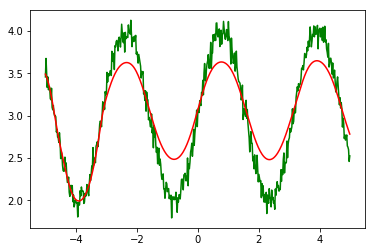

mae = 0.2189336808698301
mse = 0.07131185825605


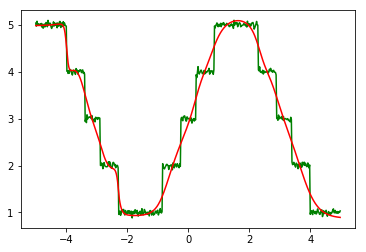

mae = 0.16873352900502386
mse = 0.050841573938634484


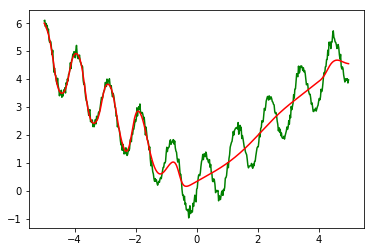

mae = 0.41050360058063584
mse = 0.27907912427879134


In [22]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resTanh_sin, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_sin,y_f1)))
print( "mse = " + str(mse(resTanh_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resTanh_round, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_round,y_f2)))
print( "mse = " + str(mse(resTanh_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resTanh_absin, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_absin,y_f3)))
print( "mse = " + str(mse(resTanh_absin,y_f3)))

### Section 2.4: Identité

In [23]:
# model without activation

mlp_id = MLP(x_batch,[8,8,8,1], ['identity','identity','identity','identity'])

# output layer
y_pred = mlp_id[-1]


# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelId = opt.minimize(avg_llh)

In [24]:
# train model
resId_sin = testFunctionActivation(5,x,y_f1,modelId)
resId_round = testFunctionActivation(5,x,y_f2,modelId)
resId_absin = testFunctionActivation(5,x,y_f3,modelId)

Loss =  5538.60209937402
Loss =  0.39167284748964676
Loss =  6555.074070805584
Loss =  0.4552426077378874
Loss =  5929.631302786232
Loss =  0.43555514646546734
Loss =  5684.945991825763
Loss =  0.42920136553917243
Loss =  5701.40398468744
Loss =  0.4866393835798637
Loss =  6383.537080561793
Loss =  2.470908921480623
Loss =  6205.1077562603405
Loss =  2.1052031820498467
Loss =  5195.978301927151
Loss =  1.9929089203369261
Loss =  6096.416825895198
Loss =  2.4259561280688833
Loss =  6593.163129884878
Loss =  2.0191978144260134
Loss =  5823.486649581156
Loss =  2.804831062925424
Loss =  6248.0228338977995
Loss =  2.6453907623426267
Loss =  5043.018987610633
Loss =  2.4999376602004375
Loss =  5554.912191532037
Loss =  3.0011735302988143
Loss =  7390.836614620913
Loss =  2.642842845588936


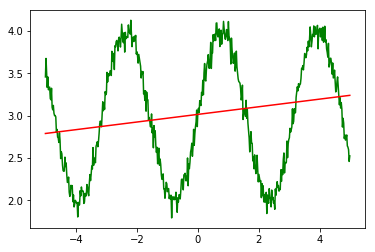

mae = 0.603380999725214
mse = 0.46493940265211176


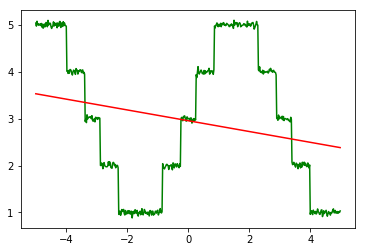

mae = 1.3178199620425304
mse = 2.2093289060629258


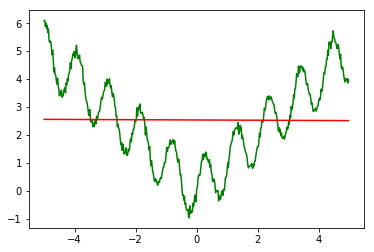

mae = 1.3553180520248158
mse = 2.6257538542257546


In [25]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resId_sin, 'red')
plt.show()

print( "mae = " + str(mae(resId_sin,y_f1)))
print( "mse = " + str(mse(resId_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resId_round, 'red')
plt.show()

print( "mae = " + str(mae(resId_round,y_f2)))
print( "mse = " + str(mse(resId_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resId_absin, 'red')
plt.show()

print( "mae = " + str(mae(resId_absin,y_f3)))
print( "mse = " + str(mse(resId_absin,y_f3)))

## Part 3: Généralisation

Dans cette partie, nous allons ajouter des indicateurs concernant la généralisation de nos algorithmes.

### Section 3.1: train/test

In [26]:
def train_test(x,y,ratio):
    union = np.hstack((x,y))
    np.random.shuffle(union)
    split = np.hsplit(union,2)
    ratio_separate = int(ratio * len(x))
    return (split[0][:ratio_separate],split[0][ratio_separate:],split[1][:ratio_separate],split[1][ratio_separate:])
    
    

In [27]:
x_train_f1,x_test_f1,y_train_f1,y_test_f1 = train_test(x,y_f1,0.8)
x_train_f2,x_test_f2,y_train_f2,y_test_f2 = train_test(x,y_f2,0.8)
x_train_f3,x_test_f3,y_train_f3,y_test_f3 = train_test(x,y_f3,0.8)

### Section 3.2: Fit with train/test

In [28]:
def Fit(x_train,x_test,y_train,y_test,model, verbose = 500):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    visualisation = []
    for epoch in range(epochs):
        indices = np.random.choice(x_train.shape[0], size=batch_size)
        x_b = x_train[indices]
        y_b = y_train[indices]
        feed_dict = {x_batch: x_b, y_batch: y_b}
        sess.run(model, feed_dict=feed_dict)
        if epoch%verbose ==0:
            feed_dict_train = {x_batch: x_train, y_batch: y_train}
            feed_dict_test = {x_batch: x_test, y_batch: y_test}
            loss_train = sess.run(avg_llh, feed_dict=feed_dict_train)
            loss_test = sess.run(avg_llh, feed_dict=feed_dict_test)
            print("Epoch: ", epoch)
            print("Loss train = ", loss_train)
            print("Loss test = ", loss_test)
            visualisation.append(np.array([epoch,loss_train,loss_test]))
    return (sess,np.array(visualisation))

In [29]:
mlp1 = MLP(x_batch,[8,8,1], ['relu','relu','identity'])

# output layer
y_pred = mlp1[-1]

# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model = opt.minimize(avg_llh)

In [30]:
# fit the model
modelFit,visu = Fit(x_train_f1,x_test_f1,y_train_f1,y_test_f1,model)

Epoch:  0
Loss train =  157.14850630579699
Loss test =  153.34726298190813
Epoch:  500
Loss train =  0.46005954909702995
Loss test =  0.4509531996818737
Epoch:  1000
Loss train =  0.4464261006446206
Loss test =  0.4454583029968477
Epoch:  1500
Loss train =  0.4414554930035369
Loss test =  0.45374736670375854
Epoch:  2000
Loss train =  0.43633032205635863
Loss test =  0.44914540025560507
Epoch:  2500
Loss train =  0.4175959304370579
Loss test =  0.4291044706089868
Epoch:  3000
Loss train =  0.3882088493820878
Loss test =  0.409328901300768
Epoch:  3500
Loss train =  0.347998937178894
Loss test =  0.3774137740918491
Epoch:  4000
Loss train =  0.3243754167449098
Loss test =  0.34957910468934783
Epoch:  4500
Loss train =  0.31636526540967486
Loss test =  0.3476419645682842
Epoch:  5000
Loss train =  0.3153990982912834
Loss test =  0.3369031633614155
Epoch:  5500
Loss train =  0.31178346213319136
Loss test =  0.3409965665934736
Epoch:  6000
Loss train =  0.3110012694387628
Loss test =  0.33

In [31]:
error = np.hsplit(visu,3)

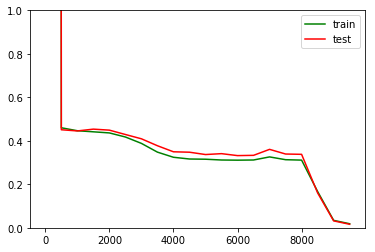

In [32]:
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

La courbe de test est plus basse .....

Il faut tester sur des données plus complexes. Nous allons voir avec les données MNIST

## Part 4: MNIST

### Section 4.1: Récupération des données

In [44]:
mnist = tf.keras.datasets.mnist

In [45]:
# download data
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [46]:
def mnist_label(i):
    label = np.zeros(10)
    label[i] = 1
    return label

In [47]:
y_train_mnist = np.array([mnist_label(y_train[i]) for i in range(len(y_train))])
y_test_mnist = np.array([mnist_label(y_test[i]) for i in range(len(y_test))])

In [48]:
#reformat data
x_train = x_train.reshape(60000,784).astype(float)
y_train = y_train_mnist.reshape(60000,10).astype(float)
x_test = x_test.reshape(10000,784).astype(float)
y_test = y_test_mnist.reshape(10000,10).astype(float)

### Section 4.2: Création d'un MLP pour la classif

In [52]:
epochs = 5000
batch_size = 1000

x_batch = tf.placeholder(shape=[None, 784], dtype=tf.float64, name='x_batch')
y_batch = tf.placeholder(shape=[None, 10], dtype=tf.int64, name='y_batch')

In [53]:
mlp_mnist = MLP(x_batch,[16,16,10], ['sigmoid','sigmoid','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model_mnist = opt.minimize(avg_llh)

In [54]:
# fit the model
modelFit_mnist,visu = Fit(x_train,x_test,y_train,y_test,model)

InvalidArgumentError: You must feed a value for placeholder tensor 'x_batch' with dtype double and shape [?,1]
	 [[{{node x_batch}} = Placeholder[dtype=DT_DOUBLE, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'x_batch', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-ca1c618b1cf0>", line 4, in <module>
    x_batch = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='x_batch')
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1745, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5020, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/home/adeleruyelle/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'x_batch' with dtype double and shape [?,1]
	 [[{{node x_batch}} = Placeholder[dtype=DT_DOUBLE, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
writer = tf.summary.FileWriter("/tmp/graph/2")
writer.add_graph(modelFit.graph)